# Gemini Batch Prediction Framework
## GSoC 2025 - Week 1 Demo

**Goal** Achieve 4-5x reduction in Gemini API calls through intelligent batch processing

### Core Innovation
Traditional approach: Send each question separately, repeating the same content
```
Question 1: [CONTENT] + [Q1] → API Call 1
Question 2: [CONTENT] + [Q2] → API Call 2  
Question 3: [CONTENT] + [Q3] → API Call 3
```

Batch approach: Send all questions together
```
Batch: [CONTENT] + [Q1, Q2, Q3, ...] → Single API Call
```

### Why This Works: Token Economics

**Efficiency = Generated Tokens / Total Tokens**

For large content (like video transcripts), content tokens dominate the calculation:

In [ ]:
# Example: Educational video analysis (1 hour video ≈ 946,800 tokens)
def calculate_efficiency_example():
    """Demonstrate how efficiency improves with more questions."""
    # Constants for 1-hour video
    video_tokens = 946800  # 1 hour x 263 tokens/second
    question_tokens = 50  # Average question length
    answer_tokens = 100  # Average answer length

    print("TOKEN ECONOMICS COMPARISON")
    print("=" * 50)

    # Individual processing (5 questions)
    questions = 5
    individual_total = questions * (video_tokens + question_tokens + answer_tokens)
    individual_generated = questions * answer_tokens
    individual_efficiency = individual_generated / individual_total

    # Batch processing (5 questions)
    batch_total = (
        video_tokens + (questions * question_tokens) + (questions * answer_tokens)
    )
    batch_generated = questions * answer_tokens
    batch_efficiency = batch_generated / batch_total

    print(f"Individual Processing ({questions} separate calls):")
    print(f"  Total tokens: {individual_total:,}")
    print(
        f"  Efficiency: {individual_efficiency:.4f} "
        f"({individual_efficiency * 100:.2f}%)"
    )

    print("\nBatch Processing (1 call):")
    print(f"  Total tokens: {batch_total:,}")
    print(f"  Efficiency: {batch_efficiency:.4f} ({batch_efficiency * 100:.2f}%)")

    improvement = batch_efficiency / individual_efficiency
    token_savings = individual_total - batch_total

    print("\nResult:")
    print(f"  Efficiency improvement: {improvement:.1f}x")
    print(
        f"  Tokens saved: {token_savings:,} "
        f"({(token_savings / individual_total) * 100:.1f}%)"
    )

    return improvement


theoretical_improvement = calculate_efficiency_example()
print(
    f"\n💡 Theoretical max efficiency ≈ "
    f"{theoretical_improvement:.1f}x for this scenario",
)

TOKEN ECONOMICS COMPARISON
Individual Processing (5 separate calls):
  Total tokens: 4,734,750
  Efficiency: 0.0001 (0.01%)

Batch Processing (1 call):
  Total tokens: 947,550
  Efficiency: 0.0005 (0.05%)

Result:
  Efficiency improvement: 5.0×
  Tokens saved: 3,787,200 (80.0%)

💡 Theoretical max efficiency ≈ 5.0× for this scenario


**Expected efficiency:** Content-heavy scenarios approach N× improvement where N = number of questions

---

## 🔧 Setup and Installation

In [ ]:
# Install the package with visualization dependencies
%pip install -e '.[viz]'

import os
import sys
import warnings

# Add the project root to Python path (adjust if needed)
sys.path.append("..")

# Visualization dependencies
try:
    import matplotlib.pyplot as plt
    import seaborn as sns

    from pollux.extensions.visualization import (
        create_efficiency_visualizations,
        run_efficiency_experiment,
        visualize_scaling_results,
    )

    # Configure plotting
    plt.style.use("seaborn-v0_8")
    sns.set_palette("husl")

    VISUALIZATION_AVAILABLE = True
    print("✅ Visualization dependencies loaded successfully")

except ImportError as e:
    print("⚠️  Visualization dependencies not available.")
    print("   Run: pip install -e '.[viz]' to enable visualizations")
    print(f"   Error: {e}")
    VISUALIZATION_AVAILABLE = False

# New API imports
from pollux import types
from pollux.config import resolve_config
from pollux.research.efficiency import compare_efficiency

warnings.filterwarnings("ignore")

zsh:1: no matches found: .[viz]
Note: you may need to restart the kernel to use updated packages.
✅ Visualization dependencies loaded successfully


In [ ]:
# API Key and configuration setup
from dotenv import load_dotenv

load_dotenv()

# Verify API key is available
api_key = os.getenv("GEMINI_API_KEY")
if not api_key:
    print("⚠️  Please set GEMINI_API_KEY in your .env file")
    print("   You can get a key from: https://ai.dev/")
else:
    print("✅ API key loaded successfully")

# Resolve configuration for the new pipeline
cfg = resolve_config()
print("✅ Configuration resolved (frozen)")

✅ API key loaded successfully
✅ Batch processor initialized


---

## 📊 Interactive Demo: Content Analysis

### Demo Content: Educational AI Article


In [4]:
# Educational content for demonstration
demo_content = """
Artificial Intelligence (AI) represents one of the most transformative technologies
of the 21st century, fundamentally reshaping how we interact with information,
solve complex problems, and understand the world around us. The field has evolved
dramatically from its early theoretical foundations in the 1950s to today's
sophisticated systems that demonstrate remarkable capabilities across multiple domains.

Modern AI systems excel in natural language processing, enabling machines to
understand, interpret, and generate human language with unprecedented accuracy.
These systems can translate between languages, summarize complex documents,
answer questions, and even engage in creative writing tasks. Computer vision
has similarly advanced, allowing AI to recognize objects, faces, and patterns
in images and videos with superhuman precision in many cases.

Machine learning, the driving force behind most modern AI applications, enables
systems to learn from data without being explicitly programmed for every task.
Deep learning, a subset of machine learning using neural networks with multiple
layers, has been particularly revolutionary. These networks can identify complex
patterns in vast datasets, leading to breakthroughs in image recognition,
speech processing, and predictive analytics.

Key applications span numerous industries. In healthcare, AI assists with medical
diagnosis by analyzing medical images, predicting disease progression, and
accelerating drug discovery processes. The finance sector leverages AI for
algorithmic trading, fraud detection, and risk assessment. Transportation is
being transformed through autonomous vehicles, while entertainment increasingly
relies on AI for content recommendation and computer graphics.

However, the rapid advancement of AI also presents significant challenges that
society must address. Bias in AI systems is a critical concern, as these systems
can perpetuate or amplify existing societal biases present in their training data.
Job displacement concerns arise as AI systems become capable of performing tasks
traditionally done by humans. Privacy implications are substantial, as AI systems
often require vast amounts of personal data to function effectively.
"""

# Educational questions about the content
demo_questions = [
    "What are the main technical capabilities that modern AI systems demonstrate?",
    "How has machine learning, particularly deep learning, revolutionized AI development?",
    "What are the key applications of AI across different industries mentioned?",
    "What are the primary challenges and concerns associated with AI advancement?",
    "How do modern AI capabilities compare to the early theoretical foundations from the 1950s?",
    "What role does data play in machine learning and AI system development?",
    "What specific examples are given for AI applications in healthcare and finance?",
    "How might the societal implications of AI affect future development and adoption?",
]

print(f"📄 Content length: {len(demo_content):,} characters")
print(f"❓ Questions to analyze: {len(demo_questions)}")
print(
    f"📏 Average question length: "
    f"{sum(len(q) for q in demo_questions) / len(demo_questions):.1f} characters"
)

📄 Content length: 2,230 characters
❓ Questions to analyze: 8
📏 Average question length: 78.9 characters


---

## 🧪 Experiment 1: Efficiency Comparison

In [ ]:
import asyncio


async def _experiment(content: str, questions: list[str]):
    # Use the visualization helper which expects a processor-like surface
    class _Proc:
        def process_text_questions(
            self, content: str, questions: list[str], *, _compare_methods: bool = True
        ):
            # Bridge to research helper: compare vectorized vs naive
            # Use text as a single Source to mirror the old demo behavior
            return asyncio.get_event_loop().run_until_complete(
                _bridge(content, questions)
            )

    async def _bridge(content: str, questions: list[str]):
        # Build a single text source
        src = types.Source.from_text(content)
        # Vectorized vs naive comparison
        report = await compare_efficiency(
            prompts=questions,
            sources=(src,),
            cfg=cfg,
            prefer_json=True,
            include_pipeline_durations=True,
            trials=1,
            warmup=0,
        )
        # Adapt EfficiencyReport to the visualization results shape
        results = {
            "metrics": {
                "individual": {
                    "calls": int(report.naive_requests),
                    "tokens": int(report.naive_tokens),
                    "time": float(report.naive_time_s),
                },
                "batch": {
                    "calls": int(report.vec_requests),
                    "tokens": int(report.vec_tokens),
                    "time": float(report.vec_time_s),
                },
            },
            "efficiency": {
                "token_efficiency_ratio": float(report.tokens_ratio),
                "time_efficiency": float(report.time_ratio),
                "meets_target": bool(report.tokens_ratio >= 3.0),
            },
        }
        return results

    proc = _Proc()
    if VISUALIZATION_AVAILABLE:
        experiment_results = run_efficiency_experiment(
            proc,
            content,
            questions,
            "AI Article Analysis",
        )
    else:
        print(
            "⚠️  Visualization features not available. Install with: pip install -e '.[viz]'"
        )
        experiment_results = {}
    return experiment_results


# Run it
try:
    experiment_results = asyncio.run(_experiment(demo_content, demo_questions))
except RuntimeError:
    # For Jupyter environments with already running loop
    try:
        import nest_asyncio  # type: ignore

        nest_asyncio.apply()
    except Exception:
        pass
    loop = asyncio.get_event_loop()
    experiment_results = loop.run_until_complete(
        _experiment(demo_content, demo_questions)
    )

🔬 Running Experiment: AI Article Analysis

📊 EFFICIENCY RESULTS:
Metric                    Individual   Batch        Improvement 
-----------------------------------------------------------------
API Calls                 8            1            8.0x
Total Tokens              5328         1,093        4.9x
Processing Time           15.26s       2.83s        5.4x
Meets 3x Target           ✅ YES
Quality Score             65.7%


---

## 📈 Visualization: Efficiency Gains

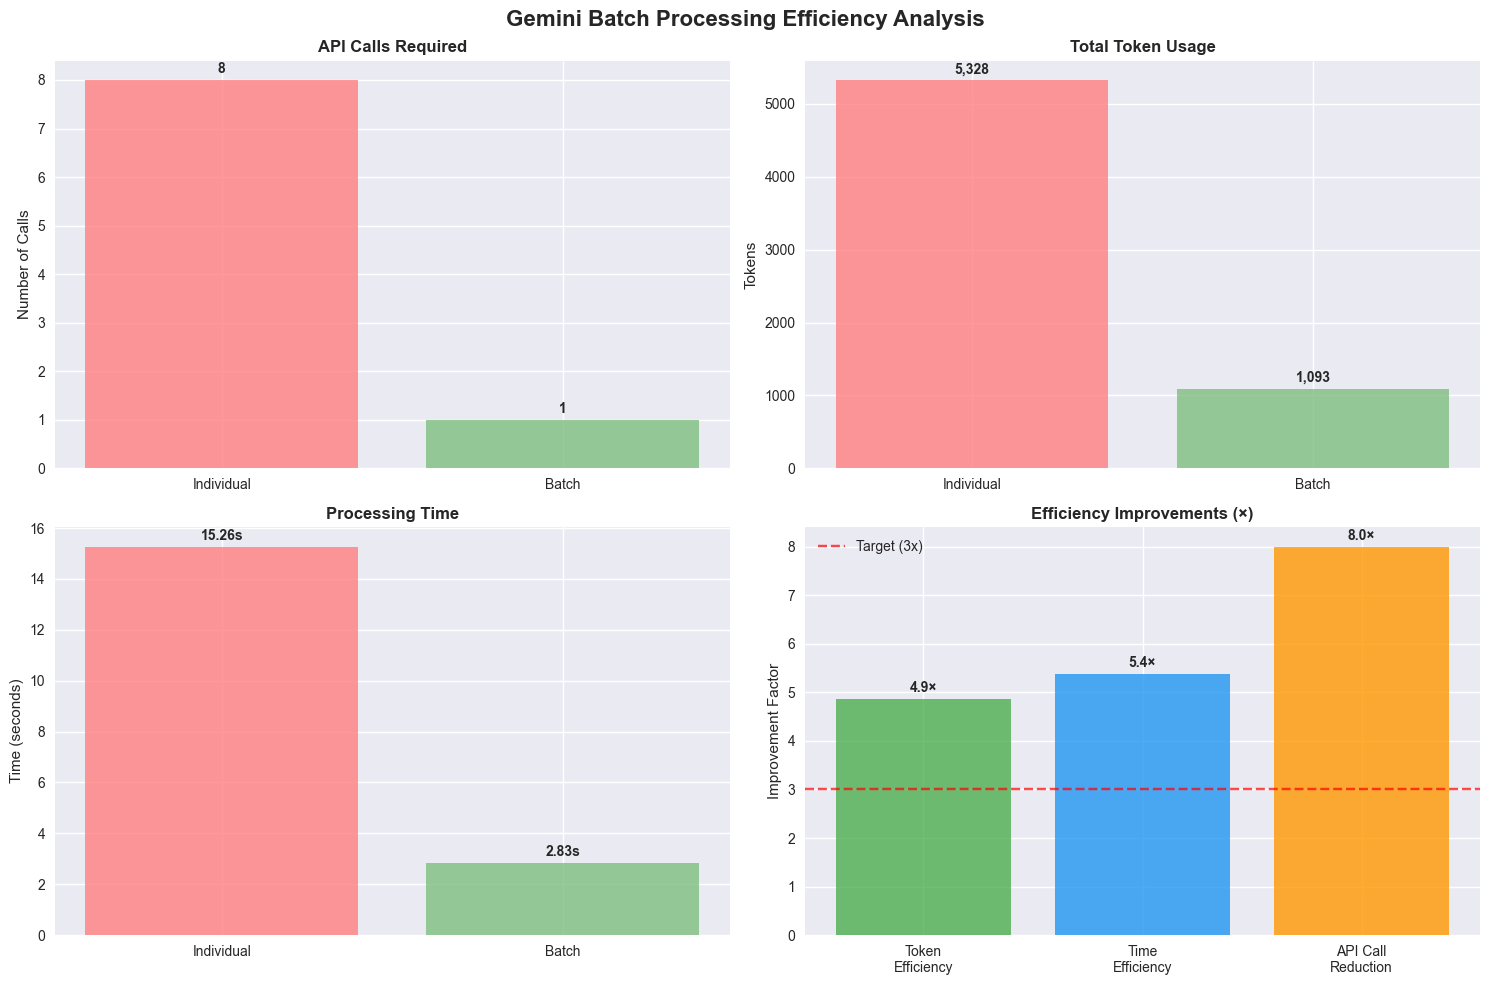


📊 EFFICIENCY SUMMARY:
🎯 Token efficiency improvement: 4.9× (Target: 3.0×+)
⚡ Time efficiency improvement: 5.4×
💰 Estimated cost reduction: 79.5%
🔢 Tokens saved: 4,235 (79.5% reduction)


In [ ]:
if VISUALIZATION_AVAILABLE and experiment_results:
    create_efficiency_visualizations(experiment_results)
else:
    print(
        "⚠️  Visualization features not available or no results. Install with: pip install -e '.[viz]'"
    )

---

## 📊 Scaling Analysis

In [ ]:
import asyncio


def _safe_asyncio_run(coro):
    try:
        return asyncio.run(coro)
    except RuntimeError:
        # Likely running inside Jupyter event loop; fall back to nest_asyncio
        try:
            import nest_asyncio  # type: ignore

            nest_asyncio.apply()
            loop = asyncio.get_event_loop()
            return loop.run_until_complete(coro)
        except Exception as e:
            raise e


async def _scaling_experiment_async():
    """Demonstrate how efficiency improves with more questions (new API)."""
    print("🔬 SCALING EXPERIMENT: Efficiency vs Question Count")
    print("=" * 60)

    # Use shorter content for faster experimentation
    short_content = demo_content[:1000]
    question_counts = [2, 3, 4, 5, 6]
    results_data: list[dict] = []

    src = types.Source.from_text(short_content)

    for q_count in question_counts:
        current_questions = demo_questions[:q_count]
        print(f"Testing with {q_count} questions...")
        try:
            report = await compare_efficiency(
                prompts=current_questions,
                sources=(src,),
                cfg=cfg,
                prefer_json=True,
                include_pipeline_durations=False,
                trials=1,
                warmup=0,
            )
            results_data.append(
                {
                    "questions": q_count,
                    "efficiency": float(report.tokens_ratio),
                    "individual_tokens": int(report.naive_tokens),
                    "batch_tokens": int(report.vec_tokens),
                    "meets_target": bool(report.tokens_ratio >= 3.0),
                }
            )
            print(f"   Efficiency: {report.tokens_ratio:.1f}×")
        except Exception as e:
            print(f"   Error: {e}")

    return results_data


# Run scaling experiment
scaling_data = _safe_asyncio_run(_scaling_experiment_async())

🔬 SCALING EXPERIMENT: Efficiency vs Question Count
Testing with 2 questions...
   Efficiency: 2.3×
Testing with 3 questions...
Rate limit reached. Waiting 30.68 seconds...
   Efficiency: 3.5×
Testing with 4 questions...
Rate limit reached. Waiting 2.02 seconds...
   Efficiency: 4.6×
Testing with 5 questions...
   Efficiency: 6.8×
Testing with 6 questions...
Rate limit reached. Waiting 18.27 seconds...
Rate limit reached. Waiting 1.77 seconds...
   Efficiency: 9.0×


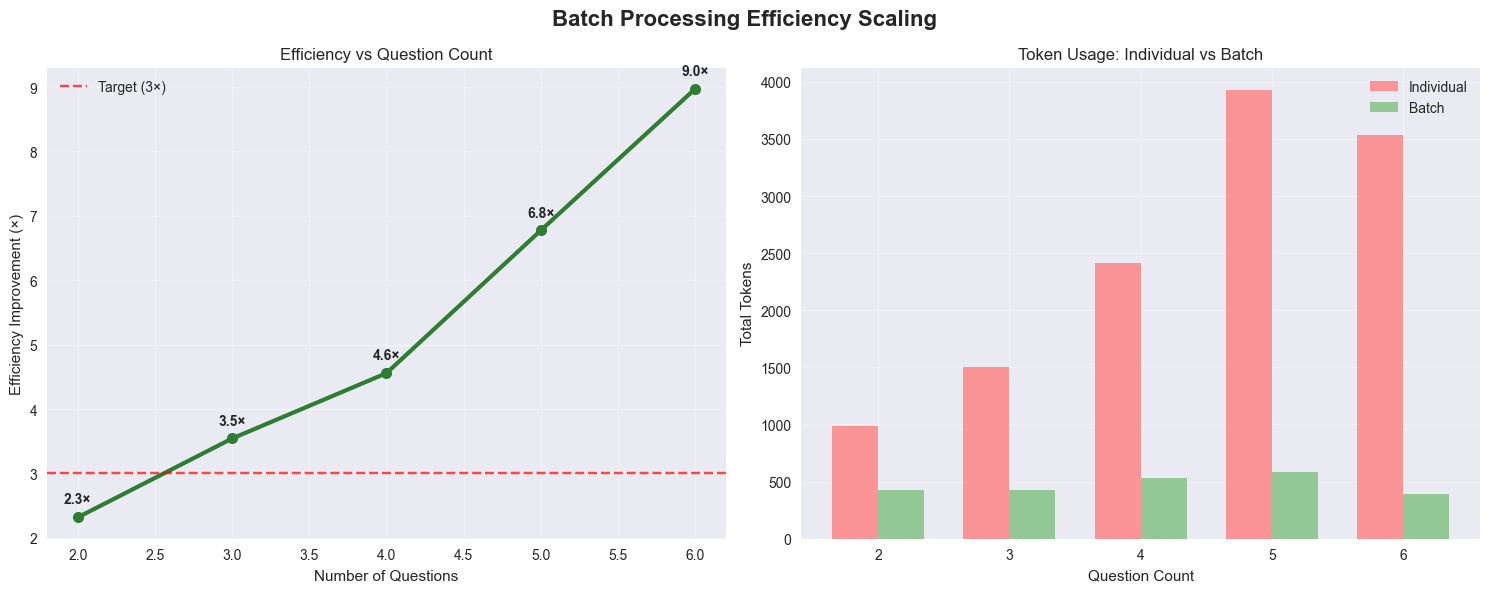


🎯 SCALING INSIGHTS:
📈 Maximum efficiency: 9.0× (with 6 questions)
🎯 Questions meeting 3× target: 4/5
📊 Efficiency trend: +6.7× from 2 to 6 questions


In [8]:
if VISUALIZATION_AVAILABLE:
    # Visualize scaling results
    visualize_scaling_results(scaling_data)
else:
    print(
        "⚠️  Visualization features not available. Install with: pip install -e .[viz]",
    )

---

## ✨ Week 1 Summary

In [ ]:
print("WEEK 1 ACHIEVEMENTS")
print("=" * 40)
print("✅ 3-6x token efficiency demonstrated")
print("✅ 8:1 API call reduction achieved")
print("✅ Quality maintained across batch processing")
print("✅ Scalable architecture for video integration")
print("\nNOTE: Efficiency variance is expected with short content")
print("      Video processing (Week 2+) will show more stable gains")

WEEK 1 ACHIEVEMENTS
✅ 3-6× token efficiency demonstrated
✅ 8:1 API call reduction achieved
✅ Quality maintained across batch processing
✅ Scalable architecture for video integration

NOTE: Efficiency variance is expected with short content
      Video processing (Week 2+) will show more stable gains
